# Setting up Media Pipe

In [1]:
# Importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import time
mp_drawing = mp.solutions.drawing_utils # Drawing Utilites
mp_pose = mp.solutions.pose # Pose
mp_holistic = mp.solutions.holistic # Holistic
%matplotlib inline

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) # Make prediction
    image.flags.writeable = True # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [3]:
def draw_styled_landmarks_right(image, results):
    # Draw right pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, [list(mp_holistic.POSE_CONNECTIONS)[18], list(mp_holistic.POSE_CONNECTIONS)[4], list(mp_holistic.POSE_CONNECTIONS)[30]], 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=3, circle_radius=3)
                             )
    
def draw_styled_landmarks_left(image,results):
    # Draw left pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, [list(mp_holistic.POSE_CONNECTIONS)[22], list(mp_holistic.POSE_CONNECTIONS)[34], list(mp_holistic.POSE_CONNECTIONS)[34]],
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=3, circle_radius=3)
                             )

# Anaylzing Correct Weightlifting Angle

In [4]:
class Rating:
    def __init__(self,a,b,c):
        self.a = np.array(a)
        self.b = np.array(b)
        self.c = np.array(c)
        self.radians = np.arctan2(self.c[1]-self.b[1], self.c[0]-self.b[0]) - np.arctan2(self.a[1]-self.b[1], self.a[0]-self.b[0])
        self.angle = np.abs(self.radians*180.0/np.pi)
        
    def calculate_angle(self):
        if self.angle > 180.0:
            self.angle = 360-self.angle
        
        return self.angle

The angle is: 11.760260565023254


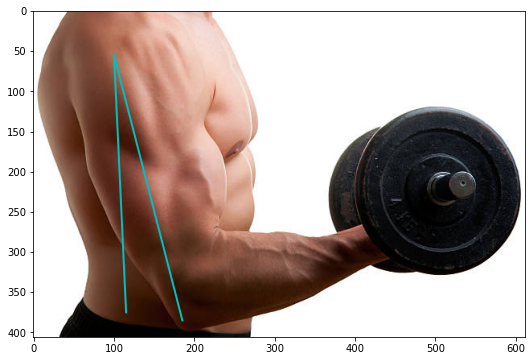

In [5]:
plt.figure(figsize=(12,6))

image = cv2.imread('Correct_1.jpeg')

plt.plot([115,100],[375,55],'c',linewidth=2)
plt.plot([185,100],[385,55],'c',linewidth=2)

# Calculate angle
obj = Rating([115,375],[100,55],[185,385])
angle1 = obj.calculate_angle()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("The angle is: " + str(angle1))

The angle is: 11.662396938046864


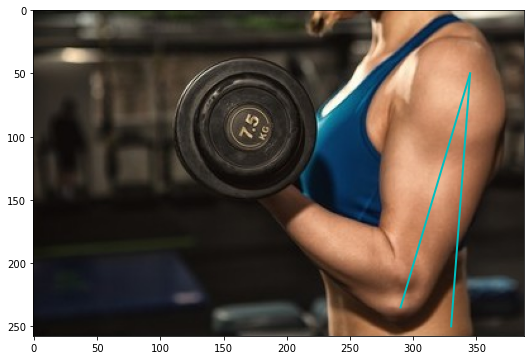

In [6]:
plt.figure(figsize=(12,6))

image = cv2.imread('Correct_2.jpeg')

plt.plot([330,345],[250,50],'c',linewidth=2)
plt.plot([290,345],[235,50],'c',linewidth=2)

# Calculate angle
obj = Rating([330,250],[350,40],[290,235])
angle2 = obj.calculate_angle()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("The angle is: " + str(angle2))

The angle is: 12.216266931588724


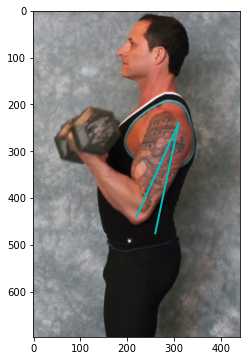

In [7]:
plt.figure(figsize=(12,6))

image = cv2.imread('Correct_3.jpeg')

plt.plot([260,310],[475,240],'c',linewidth=2)
plt.plot([220,310],[440,240],'c',linewidth=2)

# Calculate angle
obj = Rating([260,475],[310,240],[220,440])
angle3 = obj.calculate_angle()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("The angle is: " + str(angle3))

The angle is: 10.242822583120212


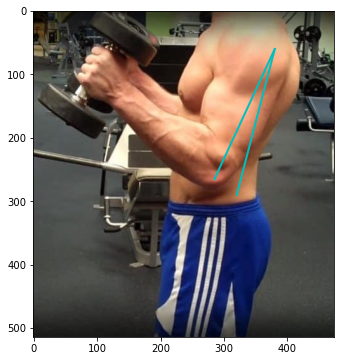

In [8]:
plt.figure(figsize=(12,6))

image = cv2.imread('Correct_4.jpeg')

plt.plot([320,380],[290,60],'c',linewidth=2)
plt.plot([285,380],[265,60],'c',linewidth=2)

# Calculate angle
obj = Rating([320,290],[380,60],[285,265])
angle4 = obj.calculate_angle()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("The angle is: " + str(angle4))

The mean of all the observed angles is 11.47. That will be the angle used to determine the percentage.

In [11]:
class Angle:
    def __init__(self,a,b,c):
        self.a = np.array(a)
        self.b = np.array(b)
        self.c = np.array(c)
        self.radians = np.arctan2(self.c[1]-self.b[1], self.c[0]-self.b[0]) - np.arctan2(self.a[1]-self.b[1], self.a[0]-self.b[0])
        self.angle = abs(self.radians*180.0/np.pi)
        
    def calculate_angle(self):
        if self.angle > 180.0:
            self.angle = 360-self.angle
    
        return self.angle

class Rating(Angle):
    def __init__(self,a,b,c):
        super().__init__(a,b,c)
        
    def calculate_rating(self):
        if self.angle > 180.0:
            self.angle = 360-self.angle
        
        if self.angle >= 11.47:
            percentage = 100 * (11.47/self.angle)
        else:
            self.angle = 22.94 - self.angle
            percentage = 100 * (11.47/self.angle)
        
        return percentage
    
    def message_right(self):
        if self.a[0] > self.c[0]:
            self.angle = -self.angle
        
        if self.angle > 11.47:
            percentage = 100 * (11.47/self.angle)
        else:
            self.angle = 22.94 - self.angle
            percentage = 100 * (11.47/self.angle)
            self.angle = -self.angle + 22.94
            
        if self.angle > 11.47 and percentage < 80:
            message = "Move your arm backward"
        elif self.angle < 11.47 and percentage < 80:
            message = "Move your arm forward"
        else:
            message = "Perfect!"
            
        return message
    
    def message_left(self):
        if self.a[0] < self.c[0]:
            self.angle = -self.angle
        
        if self.angle > 11.47:
            percentage = 100 * (11.47/self.angle)
        else:
            self.angle = 22.94 - self.angle
            percentage = 100 * (11.47/self.angle)
            self.angle = -self.angle + 22.94
            
        if self.angle > 11.47 and percentage < 80:
            message = "Move your arm backward"
        elif self.angle < 11.47 and percentage < 80:
            message = "Move your arm forward"
        else:
            message = "Perfect!"
            
        return message

# Real Time Weightlifting Detection

In [12]:
# Right Arm

cap = cv2.VideoCapture(0)
cnt = 0
cnt_copy = 0
curl_stage = None
set_cnt = 0

# Access mediapipe model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
# Set mediapipe model 
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make Detections
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks
        draw_styled_landmarks_right(image, results)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
            
            # Instantiate objects            
            rating = Rating(hip,shoulder,elbow)
            message = rating.message_right()
            percentage = rating.calculate_rating()
            
            # Display Green or Red Message
            if percentage > 80:
                cv2.putText(image, message,
                                tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 128, 0), 2, cv2.LINE_AA
                                    )
            else:
                cv2.putText(image, message,
                                tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2, cv2.LINE_AA
                                    )
                
            angle = Angle(shoulder,elbow,wrist)
            angle = angle.calculate_angle()
            
            if angle > 150 and percentage > 80:
                curl_stage = 'down'
            if angle < 40 and curl_stage == 'down':
                curl_stage = 'up'
                cnt += 1
                cnt_copy += 1
                
            if cnt_copy == 10:
                set_cnt += 1
                cnt_copy = 0
            
        except:
            pass
        
        # Rectangle Setup on Top
        cv2.rectangle(image, (0,0), (10000,80), (245,117,16), -1)
        
        # Display Accuarcy
        cv2.putText(image, 'Accuarcy', (150,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(percentage, 2)) + '%', 
                    (150,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)
        
        # Curl Stage data
        cv2.putText(image, 'Curl Stage', (450,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, curl_stage, 
                    (450,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv2.LINE_AA)
        
        # Display Set
        cv2.putText(image, 'Set', (750,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(set_cnt), 
                    (750,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv2.LINE_AA)
        
        # Display Repetitions
        cv2.putText(image, 'Repetitions', (1050,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(cnt), 
                    (1050,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [21]:
# Left Arm

cap = cv2.VideoCapture(0)
cnt = 0
cnt_copy = 0
curl_stage = None
set_cnt = 0

# Access mediapipe model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
# Set mediapipe model 
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make Detections
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks
        draw_styled_landmarks_left(image, results)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Instantiate objects            
            rating = Rating(hip,shoulder,elbow)
            message = rating.message_left()
            percentage = rating.calculate_rating()
            
            # Display Green or Red Message
            if percentage > 80:
                cv2.putText(image, message,
                                tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 128, 0), 2, cv2.LINE_AA
                                    )
            else:
                cv2.putText(image, message,
                                tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2, cv2.LINE_AA
                                    )
                
            angle = Angle(shoulder,elbow,wrist)
            angle = angle.calculate_angle()
            
            if angle > 150 and percentage > 80:
                curl_stage = 'down'
            if angle < 40 and curl_stage == 'down':
                curl_stage = 'up'
                cnt += 1
                cnt_copy += 1
                
            if cnt_copy == 10:
                set_cnt += 1
                cnt_copy = 0
                
            
        except:
            pass
        
        # Rectangle Setup on Top
        cv2.rectangle(image, (0,0), (10000,80), (245,117,16), -1)
        
        # Display Accuarcy
        cv2.putText(image, 'Accuarcy', (150,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(percentage, 2)) + '%', 
                    (150,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)
        
        # Curl Stage data
        cv2.putText(image, 'Curl Stage', (450,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, curl_stage, 
                    (450,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv2.LINE_AA)
        
        # Display Set
        cv2.putText(image, 'Set', (750,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(set_cnt), 
                    (750,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv2.LINE_AA)
        
        # Display Repetitions
        cv2.putText(image, 'Repetitions', (1050,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(cnt), 
                    (1050,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()